In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import os, glob
from scipy.stats import pearsonr
import cartopy.crs as ccrs
os.chdir("/data/dhence/a/pborse2/inputdata/data.eol.ucar.edu/pub/download/extra/katz_data/stage4/daily_data")

In [3]:
flist = [f for f in glob.glob('*.nc')] ## Yearly precipitation files
flist.sort()

In [4]:
def masked(ncfile): #Take the nc file as input
    # This csv file is used to select contiguous US
    state_df = pd.read_csv('/data/dhence/a/pborse2/inputdata/state_lookup.csv')
    state_df = state_df.loc[state_df['ContiguousUS'] == 1]
    # Shpfile for counties in US
    counties = pd.read_csv('/data/dhence/a/pborse2/inputdata/USA_Counties/USA_Counties.csv')
    counties['geometry'] = gpd.GeoSeries.from_wkt(counties['geometry'])
    counties = gpd.GeoDataFrame(counties, geometry='geometry').set_crs('epsg:3857')

    counties = counties.loc[counties['STATE_NAME'].isin(state_df['Name'])]
#     champ = gpd.read_file('/data/dhence/a/pborse2/inputdata/Champaign Zoning/Zoning.shp')
    
    # Reproject the counties gdf to polar stereographic projection
    # It is the most appropriate to match the netcdf's projection to display the contiguous US
    import cartopy.crs as ccrs
    crs = ccrs.NorthPolarStereo()
    crs_proj4 = crs.proj4_init
    counties1 = counties.to_crs(crs_proj4)
    counties1 = counties1.rotate(105, origin=(0,0))
    counties['geometry'] = counties1
    
#     ch1 = champ.to_crs(crs_proj4) ##Reprojecting shapefile for champaign city
#     ch1 = ch1.rotate(105, origin=(0,0))
#     champ['geometry']=ch1
    
    f = xr.open_dataarray(ncfile) ####INPUT ALERT####
    lonm = [((x-401)*4762.5) for x in f.x]
    latm = [((y-1601)*4762.5)-375237.5 for y in f.y] ##These formulae come from https://www.caee.utexas.edu/prof/maidment/gishyd97/library/nexrad/Sect3.pdf
    ###Value of latm is adjusted according to shapefile by subtracting 375237.5 in order to mask out correct region
#     lonm = [((x-401)*4762.5) for x in f.x]
#     latm = [((y-1601)*4762.5) for y in f.y]

    f['x']=lonm
    f['y']=latm
    
    #Assign a CRS to nc file as it's CRS is unknown in documentation but from website, it is polar stereographic 
    f = f.rio.write_crs(crs_proj4 , inplace=True)
    
    ## Mask out region of interest
#     import salem
    f.attrs['pyproj_srs'] = crs_proj4
#     ds = f.salem.roi(shape=counties[(counties['STATE_NAME']=='Illinois')&(counties['NAME']=='Champaign')])
    return counties, f

Text(0.5, 1.0, 'Date=2004-06-10')

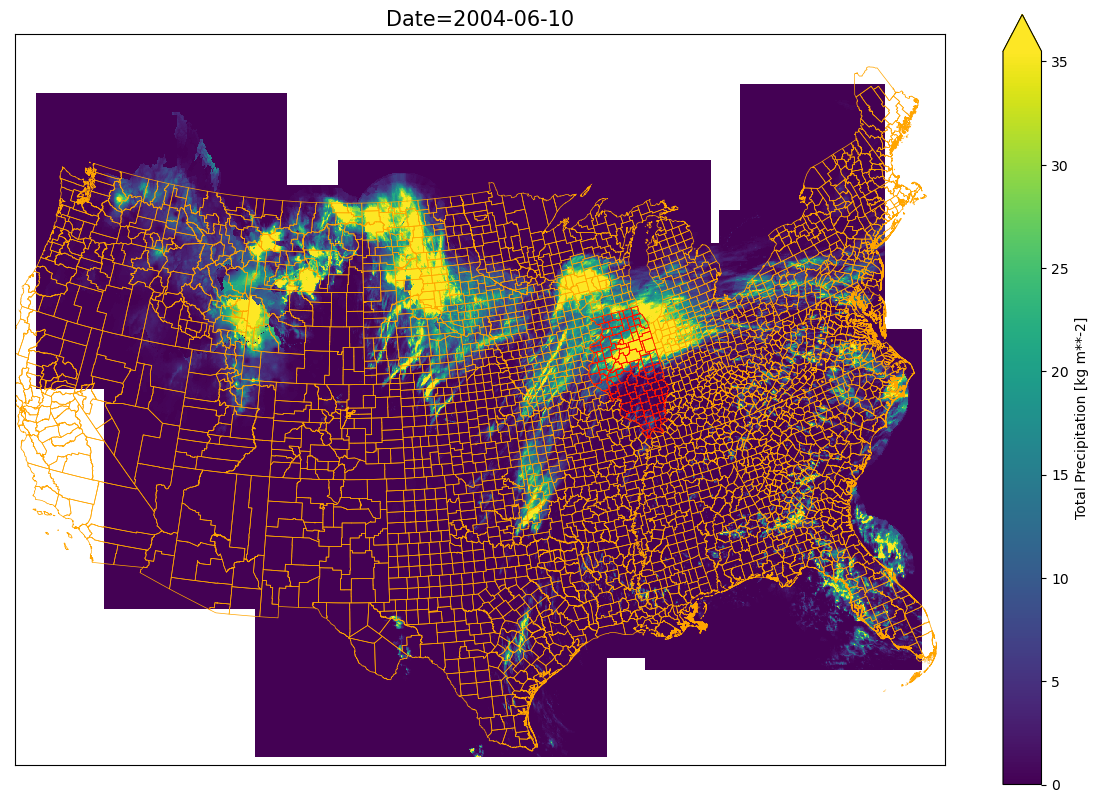

In [6]:
f=masked(flist[2])
fig, ax = plt.subplots(figsize=(15, 10))
f[1].sel(time="2004-6-10").plot(ax=ax,robust=True)
counties = f[0]
counties.boundary.plot(ax=ax, lw=0.5, color='orange')
counties[counties['STATE_NAME']=='Illinois'].boundary.plot(ax=ax, lw=0.5, color='red')

# You can use this to hide the numbers on both axis

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Date=2004-06-10',fontsize=15)


In [9]:
gdf

,Unnamed: 0,NAME,STATE_NAME,POP2010,POP10_SQMI,POP2012,POP12_SQMI,WHITE,BLACK,AMERI_ES,...,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,NO_FARMS07,AVG_SIZE07,CROP_ACR07,AVG_SALE07,SQMI,geometry
0,0,Graham,Arizona,37220,8.0,37745,8.132560,26827,683,5376,...,12980,1860,8089,3031,343.0,3923.0,35251.0,-99.00,4641.22,"MULTIPOLYGON (((-12217131.319 3959728.262, -12..."
1,1,Greenlee,Arizona,8437,4.6,8962,4.848649,6514,89,195,...,4372,1184,1593,1595,127.0,278.0,6687.0,48.90,1848.35,"POLYGON ((-12139871.371 3999069.283, -12139050..."
2,2,Bureau,Illinois,34978,40.1,35095,40.185728,32937,212,98,...,15720,1458,10845,3417,1189.0,402.0,439887.0,255.14,873.32,"POLYGON ((-9925971.867 5099065.657, -9925971.4..."
3,3,La Paz,Arizona,20489,4.5,20586,4.561297,14306,129,2628,...,16049,6851,7072,2126,99.0,-99.0,123314.0,1379.73,4513.19,"MULTIPOLYGON (((-12720330.271 3924275.838, -12..."
4,4,Calhoun,Illinois,5089,17.9,5109,18.010364,5032,7,9,...,2835,750,1681,404,464.0,190.0,49579.0,40.22,283.67,"POLYGON ((-10116327.032 4779103.377, -10116308..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216,3216,Vega Baja,Puerto Rico,-99,-99.0,-99,-99.000000,-99,-99,-99,...,-99,-99,-99,-99,-99.0,-99.0,-99.0,-99.00,46.52,"MULTIPOLYGON (((-7389092.135 2095082.949, -738..."
3217,3217,Vieques,Puerto Rico,-99,-99.0,-99,-99.000000,-99,-99,-99,...,-99,-99,-99,-99,-99.0,-99.0,-99.0,-99.00,51.00,"POLYGON ((-7287931.984 2048045.066, -7287936.3..."
3218,3218,Villalba,Puerto Rico,-99,-99.0,-99,-99.000000,-99,-99,-99,...,-99,-99,-99,-99,-99.0,-99.0,-99.0,-99.00,36.98,"POLYGON ((-7398679.094 2058408.740, -7398662.7..."
3219,3219,Yabucoa,Puerto Rico,-99,-99.0,-99,-99.000000,-99,-99,-99,...,-99,-99,-99,-99,-99.0,-99.0,-99.0,-99.00,55.03,"MULTIPOLYGON (((-7324309.318 2045566.508, -732..."


In [7]:
f = pd.read_csv('/data/dhence/a/pborse2/inputdata/USA_Counties/USA_Counties.csv')
f['geometry'] = gpd.GeoSeries.from_wkt(f['geometry'])